
## 1. Введение и Постановка Задачи

**Цель:** Разработать модель бинарной классификации для предсказания целевой переменной на основе предоставленных данных о заемщиках.

**Метрика качества:** ROC-AUC.

**Подход:** я буду использовать градиентный бустинг (LightGBM) как наиболее эффективный алгоритм для табличных данных. Основной упор будет сделан на качественный разведочный анализ данных (EDA), генерацию сильных признаков (Feature Engineering) и надежную кросс-валидацию (Stratified K-Fold).

## 2. Настройка окружения и Загрузка библиотек

In [1]:
!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content


/content


In [4]:
!rm -rf LightGBM


In [5]:
!ls -l


total 8
drwx------ 5 root root 4096 Aug  6 14:23 drive
drwxr-xr-x 1 root root 4096 Jul 29 13:36 sample_data


In [6]:
%%bash



In [7]:
%%bash
apt-get update -y
apt-get install -y build-essential cmake libboost-dev opencl-headers


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.9ubuntu3).
libboost-dev is already the newest version (1.74.0.3ubuntu7).
opencl-headers is already the newest version (3.0~2022.01.0

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [8]:
%%bash
mkdir -p /etc/OpenCL/vendors
echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd


In [9]:
%%bash
# Remove any previous source build attempt
rm -rf /content/LightGBM

# Install LightGBM with GPU support using pip
pip install lightgbm --config-settings=install.cmake.args="-DUSE_GPU=1" --config-settings=install.cmake.build-args="-j$(nproc)"

In [10]:
import lightgbm as lgb
print("LightGBM", lgb.__version__)
# The way to check for GPU support has changed in newer versions.
# The previous method using lightgbm.compat.DEVICE_TYPE is no longer valid.
# To confirm GPU usage, set device_type='gpu' in the model parameters and
# check the output during training if verbose is enabled.

# Removed the problematic import and check for DEVICE_TYPE
# from lightgbm.compat import DEVICE_TYPE
# print("Поддержка GPU:", DEVICE_TYPE.gpu in lgb.basic._get_device_type())

LightGBM 4.6.0


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import re
from datetime import datetime
import time

from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from catboost import CatBoostClassifier

# !!! НОВОЕ (Итерация 7): Импорты для Стекинга и Оптимизации
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
# ---------------------------------------
#  (Итерация 6): Импорты для Нейросети !!!
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Проверка импорта Pytorch Tabular
try:
    from pytorch_tabular import TabularModel
    from pytorch_tabular.models import FTTransformerConfig
    from pytorch_tabular.config import (
        DataConfig, OptimizerConfig, TrainerConfig
    )
except ImportError as e:
    print(f"Ошибка импорта Pytorch Tabular. Убедитесь, что установка прошла успешно. Ошибка: {e}")
# --------------------------------------------------

# Настройки
warnings.filterwarnings('ignore')
# Увеличиваем лимит отображаемых колонок, так как их много
pd.set_option('display.max_columns', 150)
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) # Отображение чисел без научной нотации
sns.set(style="whitegrid")

# Константы для воспроизводимости и настройки
RANDOM_STATE = 42
N_SPLITS = 5 # Количество фолдов для кросс-валидации. Оптимально для большинства задач.
# Используем большое число итераций и Early Stopping для определения оптимального количества деревьев
N_ESTIMATORS = 5000
EARLY_STOPPING_ROUNDS = 150
VERBOSE = False # Отключаем подробный вывод во время обучения
# Используем предполагаемую текущую дату из контекста для расчета давности событий
REFERENCE_DATE = datetime(2025, 8, 1)

# !!! НОВОЕ: Фиксация seed для PyTorch
torch.manual_seed(RANDOM_STATE)
# ...
# Моделирование и оценка
from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder # Не используем, так как LGBM поддерживает категории нативно
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

# Настройки
warnings.filterwarnings('ignore')
# Увеличиваем лимит отображаемых колонок, так как их много
pd.set_option('display.max_columns', 150)
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) # Отображение чисел без научной нотации
sns.set(style="whitegrid")

Ошибка импорта Pytorch Tabular. Убедитесь, что установка прошла успешно. Ошибка: No module named 'pytorch_tabular'


## 3. Загрузка данных

Загружаем тренировочные и тестовые данные. На больших датасетах.


In [12]:
# Шаг 2. Загружаем CSV-файлы

# --- КОНФИГУРАЦИЯ ---
TRAIN_FILE_PATH ='/content/drive/MyDrive/shift_ml_2025_train.csv'
TEST_FILE_PATH = '/content/drive/MyDrive/shift_ml_2025_test.csv'

TARGET_NAME = 'итоговый_статус_займа'
ID_COLUMN = 'id'
# --------------------

# !!! Итерация 4: Функция для очистки числовых строк (Чек-лист №4) !!!
def convert_numeric_strings(df):
    print("Конвертация числовых строк в numeric...")
    converted_count = 0
    # Выбираем колонки типа object
    for c in df.select_dtypes('object').columns:
        # Заменяем запятые на точки (если они используются как разделители)
        tmp = df[c].astype(str).str.replace(',', '.')

        # Проверяем, состоит ли колонка в основном из чисел (регулярное выражение)
        # Если >80% строк похожи на числа, конвертируем
        if tmp.str.match(r'^-?\d+\.?\d*$', na=False).mean() > 0.8:
            # Конвертируем в число, ошибки превращаем в NaN (errors='coerce')
            df[c] = pd.to_numeric(tmp, errors='coerce')
            converted_count += 1
    print(f"  Конвертировано колонок: {converted_count}")
    return df

try:
    # Используем low_memory=False для надежности
    # Specify encoding to handle potential issues with Cyrillic characters
    train_df = pd.read_csv(TRAIN_FILE_PATH)
    test_df = pd.read_csv(TEST_FILE_PATH)

    # Применяем конвертацию
    train_df = convert_numeric_strings(train_df)
    test_df = convert_numeric_strings(test_df)

    print(f"\nРеальные данные загружены и обработаны. Train: {train_df.shape}, Test: {test_df.shape}")

except FileNotFoundError:
    print(f"Ошибка: Файлы не найдены по указанным путям.")
except Exception as e:
    print(f"Произошла ошибка при загрузке: {e}")

Конвертация числовых строк в numeric...
  Конвертировано колонок: 0
Конвертация числовых строк в numeric...
  Конвертировано колонок: 0

Реальные данные загружены и обработаны. Train: (1210779, 109), Test: (134531, 108)


## 3.1. Добавление класса для Target Encoding

In [13]:
# Вспомогательный класс для K-Fold Target Encoding с сглаживанием и минимальным порогом
class TargetEncoder:
    # !!! Итерация 3: Уменьшили smoothing по умолчанию и добавили min_count !!!
    def __init__(self, cols, smoothing=5.0, min_count=10):
        self.cols = cols
        self.smoothing = smoothing
        self.min_count = min_count # Категории с количеством меньше min_count получат глобальное среднее
        self.global_mean = None
        self.maps = {}

    def fit(self, X, y):
        X = X.astype(str)
        self.global_mean = y.mean()
        for col in self.cols:
            if col in X.columns:
                stats = y.groupby(X[col]).agg(['mean', 'count'])

                # !!! Фильтр: игнорируем редкие категории
                stats = stats[stats['count'] >= self.min_count]

                # Расчет сглаженного среднего
                smooth = (stats['count'] * stats['mean'] + self.smoothing * self.global_mean) / (stats['count'] + self.smoothing)
                self.maps[col] = smooth

    def transform(self, X):
        X = X.astype(str)
        X_encoded = pd.DataFrame(index=X.index)
        for col in self.cols:
            if col in X.columns and col in self.maps:
                # Применяем маппинг. Новые или редкие (отфильтрованные) категории заполняем глобальным средним.
                X_encoded[f'{col}_TE'] = X[col].map(self.maps[col]).fillna(self.global_mean)
        return X_encoded

print("Класс TargetEncoder обновлен (с smoothing и min_count).")

Класс TargetEncoder обновлен (с smoothing и min_count).


## 4. EDA (Разведочный анализ данных)

### 4.1. Анализ целевой переменной

Оценим баланс классов.

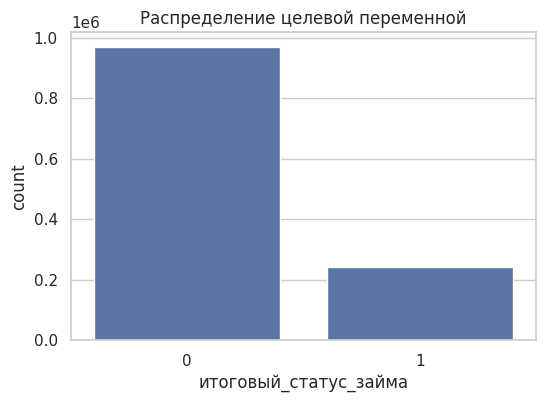

Распределение классов (%):
итоговый_статус_займа
0   80.03814
1   19.96186
Name: proportion, dtype: float64


In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x=TARGET_NAME, data=train_df)
plt.title('Распределение целевой переменной')
plt.show()

print("Распределение классов (%):")
print(train_df[TARGET_NAME].value_counts(normalize=True) * 100)

### 4.2. Анализ пропущенных значений

Определим, какие признаки содержат много пропусков. Это влияет на  заполнения  или удаления признаков.

In [15]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Кол-во пропусков', 1 : '% от общего числа'})
    # Сортировка по убыванию процента пропусков
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% от общего числа', ascending=False).round(1)
    return mis_val_table_ren_columns

print("Топ-20 признаков с пропусками в Train:")
missing_stats = missing_values_table(train_df)
display(missing_stats.head(20))

Топ-20 признаков с пропусками в Train:


,Кол-во пропусков,% от общего числа
дата_следующей_выплаты,1210779,100.00000
кредитный_баланс_по_возоб_счетам,1193971,98.60000
совокупный_статус_подтверждения_доходов_заемщиков,1187729,98.10000
совокупный_пдн_заемщиков,1187548,98.10000
совокупный_доход_заемщиков,1187546,98.10000
кол-во_месяцев_с_последнего_займа,1005117,83.00000
кол-во_мес_с_последней_задолженности_по_карте,923517,76.30000
кол-во_месяцев_с_последнего_нарушения,892120,73.70000
кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,805599,66.50000
соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,792391,65.40000


### 4.2.1. Удаление признаков с высокой долей пропусков и потенциальных утечек

На основе анализа пропусков, мы удалим признаки, заполненные менее чем на 5%.

Также, признак `пени_за_дефолт` показал аномально высокую важность. Это сильный индикатор **утечки данных (Data Leak)**. Мы обязаны его удалить для построения корректной модели.

In [16]:
# 1. Определение признаков с слишком большим количеством пропусков
MISSING_THRESHOLD = 95 # Удаляем все, что выше 95%
# Используем статистику missing_stats, рассчитанную ранее в Ячейке 10
cols_to_drop_missing = missing_stats[missing_stats['% от общего числа'] > MISSING_THRESHOLD].index.tolist()
print(f"Количество признаков для удаления (>{MISSING_THRESHOLD}% пропусков): {len(cols_to_drop_missing)}")

# 2. Определение потенциальных утечек
cols_to_drop_leaks = ['пени_за_дефолт']
print(f"Удаляем потенциальные утечки: {cols_to_drop_leaks}")

# Финальный список на удаление
COLS_TO_DROP = list(set(cols_to_drop_missing + cols_to_drop_leaks))

# Функция для удаления этих признаков (будет применена позже при объединении)
def drop_useless_features(df, cols_to_drop):
    # Убедимся, что колонки существуют перед удалением (игнорируем таргет, если он попал в список)
    # TARGET_NAME может не быть определен, если вы запускаете ячейки не по порядку, но мы его защитим.
    target_name = globals().get('TARGET_NAME', 'default_target_name')

    cols_exist = [col for col in cols_to_drop if col in df.columns and col != target_name]
    df = df.drop(columns=cols_exist)
    return df

Количество признаков для удаления (>95% пропусков): 5
Удаляем потенциальные утечки: ['пени_за_дефолт']


### 4.3. Анализ типов признаков и Кардинальности

Разделим признаки на числовые и категориальные и оценим количество уникальных значений  в категориальных.

In [17]:
features = [col for col in train_df.columns if col not in [ID_COLUMN, TARGET_NAME]]
categorical_features = train_df[features].select_dtypes(include=['object', 'category']).columns
numerical_features = train_df[features].select_dtypes(include=np.number).columns

print(f"Числовые признаки: {len(numerical_features)}")
print(f"Категориальные признаки: {len(categorical_features)}")

print("\nКардинальность категориальных признаков (Топ-15):")
cardinality = train_df[categorical_features].nunique().sort_values(ascending=False)
display(cardinality.head(15))

Числовые признаки: 88
Категориальные признаки: 19

Кардинальность категориальных признаков (Топ-15):


,0
профессия_заемщика,273666
дата_первого_займа,738
регион,51
допрейтинг,35
цель_займа,14
стаж,11
рейтинг,7
владение_жильем,6
совокупный_статус_подтверждения_доходов_заемщиков,3
пос_стоп_фактор,3


## 5. Feature Engineering и Предобработка

Это ключевой этап для достижения высокого скора. Мы объединим train и test для консистентной обработки признаков, что предотвращает утечки данных и гарантирует наличие одинаковых колонок в обеих выборках.

In [18]:
# Сохраняем ID и таргет
train_ids = train_df[ID_COLUMN]
test_ids = test_df[ID_COLUMN]
train_target = train_df[TARGET_NAME]

# Удаляем ID и Target перед объединением
train_df_processed = train_df.drop(columns=[ID_COLUMN, TARGET_NAME])
# Используем errors='ignore' на случай, если в тестовом файле нет колонки ID (хотя она должна быть)
test_df_processed = test_df.drop(columns=[ID_COLUMN], errors='ignore')

# Добавляем метку для последующего разделения
train_df_processed['is_train'] = 1
test_df_processed['is_train'] = 0

# Объединяем
df = pd.concat([train_df_processed, test_df_processed], ignore_index=True)

print(f"Объединенный размер данных до FE и очистки: {df.shape}")

# !!! НОВОЕ: Применяем удаление бесполезных признаков и утечек !!!
df = drop_useless_features(df, COLS_TO_DROP)
print(f"Размер после удаления бесполезных признаков и утечек: {df.shape}")

# Очистка памяти от исходных датафреймов
del train_df, test_df, train_df_processed, test_df_processed
gc.collect()

Объединенный размер данных до FE и очистки: (1345310, 108)
Размер после удаления бесполезных признаков и утечек: (1345310, 102)


222

### 5.1. Очистка и Преобразование признаков

Напишем функцию для обработки "сырых" данных. Это обеспечивает структурированность и воспроизводимость кода. Мы фокусируемся на обработке дат, стажа, сроков и информативных пропусков.

In [19]:
def clean_features(df):
    print("Начало очистки признаков...")
     # !!! Итерация 5: Обработка подозрительных констант (На основе анализа сэмпла) !!!
    # 'коэфф_невыплаченного_сумм_остатка' имеет постоянное значение ~1345311.5.
    # Заменяем значения, близкие к этому, на NaN.
    if 'коэфф_невыплаченного_сумм_остатка' in df.columns:
        # Убедимся, что колонка числовая
        if np.issubdtype(df['коэфф_невыплаченного_сумм_остатка'].dtype, np.number):
            suspicious_value = 1345311.5
            tolerance = 1.0 # Допуск для сравнения чисел с плавающей точкой
            # Используем .mask() для замены значений в пределах допуска на NaN
            df['коэфф_невыплаченного_сумм_остатка'] = df['коэфф_невыплаченного_сумм_остатка'].mask(
                (df['коэфф_невыплаченного_сумм_остатка'] >= suspicious_value - tolerance) &
                (df['коэфф_невыплаченного_сумм_остатка'] <= suspicious_value + tolerance),
                np.nan
            )
            print("  Обработан 'коэфф_невыплаченного_сумм_остатка'.")
    # !!! Iteration 4 (Checklist #5): Add NaN flags for columns with >70% missing values
    # Do this at the beginning, before filling missing values.
    NAN_FLAG_THRESHOLD = 0.7
    # Calculate missing value ratios
    missing_ratios = df.isna().mean()
    hi_missing_cols = missing_ratios[missing_ratios > NAN_FLAG_THRESHOLD].index

    print(f"Creating NaN flags for {len(hi_missing_cols)} columns (>{NAN_FLAG_THRESHOLD*100:.0f}% missing)...")
    for c in hi_missing_cols:
        # Protect against creating flags for system columns (e.g., 'is_train')
        if c in df.columns and c != 'is_train':
            df[f'{c}_isnan'] = df[c].isna().astype(int)

    # 1. Process 'стаж'
    if 'стаж' in df.columns:
        df['стаж_лет'] = df['стаж'].replace({'< 1 года': 0, '10+ лет': 10})
        # Check if already numeric after step 1
        if pd.api.types.is_object_dtype(df['стаж_лет']):
            df['стаж_лет'] = df['стаж_лет'].str.extract('(\d+)').astype(float)
        else:
            df['стаж_лет'] = df['стаж_лет'].astype(float)
        df['стаж_пропущен'] = df['стаж_лет'].isnull().astype(int)

    # 2. Process 'срок_займа' (Iteration 4: Checklist #2 fix)
    if 'срок_займа' in df.columns:
        raw = df['срок_займа'].astype(str)
        val = raw.str.extract('(\d+)').astype(float).iloc[:, 0]
        is_months = raw.str.contains('ме', case=False, na=False)
        df['срок_займа_мес'] = np.where(is_months, val, val * 12)

    # 3. Process dates ('дата_первого_займа')
    if 'дата_первого_займа' in df.columns:
        try:
            df['дата_первого_займа_dt'] = pd.to_datetime(df['дата_первого_займа'], format='%m-%Y', errors='coerce')
        except Exception:
            df['дата_первого_займа_dt'] = pd.to_datetime(df['дата_первого_займа'], errors='coerce')
        if 'дата_первого_займа_dt' in df.columns:
            df['давность_первого_займа_мес'] = (
                (REFERENCE_DATE.year - df['дата_первого_займа_dt'].dt.year) * 12 +
                (REFERENCE_DATE.month - df['дата_первого_займа_dt'].dt.month)
            )
            df = df.drop('дата_первого_займа_dt', axis=1)

    # 4. Process missing values in delinquency history (Iteration 4: Checklist #3)
    # Use regex to find all columns related to delinquency/violation recency
    regex_pattern = r'последн.*(просрочк|нарушен)'
    cols_delinquency = [col for col in df.columns if re.search(regex_pattern, col, re.IGNORECASE)]
    print(f"Found {len(cols_delinquency)} delinquency recency columns (Regex).")
    for col in cols_delinquency:
        # Create binary event indicator
        df[f'{col}_флаг_события'] = df[col].notna().astype(int)
        # Fill missing with large value (9999)
        df[col] = df[col].fillna(9999)

    # 5. Process ratings (same as Iteration 3)
    grade_map = {'А': 7, 'Б': 6, 'В': 5, 'Г': 4, 'Д': 3, 'Е': 2, 'Ж': 1}
    if 'рейтинг' in df.columns:
        df['рейтинг_числовой'] = df['рейтинг'].map(grade_map)

    # Simplified encoding for 'допрейтинг' (same as Iteration 3)
    if 'допрейтинг' in df.columns:
        df['допрейтинг_temp'] = df['допрейтинг'].astype(str).fillna('MISSING')
        df['допрейтинг_буква_ordinal'] = df['допрейтинг_temp'].str[0].map(grade_map).fillna(0)
        df['допрейтинг_цифра_numeric'] = pd.to_numeric(df['допрейтинг_temp'].str[1:], errors='coerce').fillna(0)
        df['допрейтинг_цифра_log'] = np.log1p(df['допрейтинг_цифра_numeric'])
        df = df.drop(columns=['допрейтинг_temp'], errors='ignore')

    # Remove original columns that were transformed
    cols_to_drop = ['стаж', 'срок_займа', 'дата_первого_займа']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    print("Очистка признаков завершена.")
    return df

df = clean_features(df)

Начало очистки признаков...
  Обработан 'коэфф_невыплаченного_сумм_остатка'.
Creating NaN flags for 4 columns (>70% missing)...
Found 3 delinquency recency columns (Regex).
Очистка признаков завершена.


### 5.2. Генерация Новых Признаков (Feature Engineering)

Используем знания предметной области (кредитный скоринг) для создания новых, более сильных предикторов. Отношения между финансовыми показателями часто работают лучше, чем абсолютные значения.

In [20]:
def generate_features(df):
    print("Начало генерации признаков...")

    # !!! Итерация 5: Эффективный Доход и ПДН (Учет совместных займов) !!!
    # Если тип_займа == 'Совместный' И совокупный_доход не NaN, используем его, иначе - индивидуальный.

    # 1. Эффективный Доход
    # Создаем базовый фоллбэк
    df['эффективный_годовой_доход'] = df.get('годовой_доход', np.nan)

    if 'тип_займа' in df.columns and 'совокупный_доход_заемщиков' in df.columns and 'годовой_доход' in df.columns:
        # Проверяем, что колонки существуют и являются числовыми
        if np.issubdtype(df['совокупный_доход_заемщиков'].dtype, np.number) and np.issubdtype(df['годовой_доход'].dtype, np.number):
            is_joint = (df['тип_займа'] == 'Совместный') & (df['совокупный_доход_заемщиков'].notna())
            df['эффективный_годовой_доход'] = np.where(is_joint, df['совокупный_доход_заемщиков'], df['годовой_доход'])

    # 2. Эффективный ПДН
    df['эффективный_пдн'] = df.get('пдн', np.nan)

    if 'тип_займа' in df.columns and 'совокупный_пдн_заемщиков' in df.columns and 'пдн' in df.columns:
        if np.issubdtype(df['совокупный_пдн_заемщиков'].dtype, np.number) and np.issubdtype(df['пдн'].dtype, np.number):
            is_joint = (df['тип_займа'] == 'Совместный') & (df['совокупный_пдн_заемщиков'].notna())
            df['эффективный_пдн'] = np.where(is_joint, df['совокупный_пдн_заемщиков'], df['пдн'])


    # --- Ключевые коэффициенты Долговой Нагрузки (!!! Обновлено: используем Эффективные признаки !!!) ---

    df['PTI'] = (df['аннуитет'] * 12) / (df['эффективный_годовой_доход'] + 1e-6)
    df['LTI'] = df['сумма_займа'] / (df['эффективный_годовой_доход'] + 1e-6)
    df['аннуитет_к_займу'] = df['аннуитет'] / (df['сумма_займа'] + 1e-6)

    if 'рейтинг_числовой' in df.columns:
        df['ставка_к_рейтингу'] = df['процентная_ставка'] / (df['рейтинг_числовой'] + 1e-6)

    # --- Взаимодействия (Обновляем те, что зависят от дохода/пдн) ---
    if 'стаж_лет' in df.columns:
        # !!! Обновлено: используем Эффективный Доход !!!
        df['доход_к_стажу'] = df['эффективный_годовой_доход'] / (df['стаж_лет'].fillna(0) + 1)

    if 'стаж_лет' in df.columns and 'давность_первого_займа_мес' in df.columns:
         df['стаж_к_кредитной_истории'] = df['стаж_лет'] / (df['давность_первого_займа_мес'] / 12 + 1e-6)

    # !!! Обновлено: используем Эффективный ПДН !!!
    if 'эффективный_пдн' in df.columns:
        # Удаляем старый признак, если он был создан по колонке 'пдн'
        df = df.drop(columns=['пдн_х_ставка'], errors='ignore')
        df['пдн_х_ставка'] = df['эффективный_пдн'] * df['процентная_ставка']

    if 'допрейтинг_буква_ordinal' in df.columns:
        df['допрейтинг_ordinal_х_ставка'] = df['допрейтинг_буква_ordinal'] * df['процентная_ставка']


    # --- Временные взаимодействия и Плотность Активности (Остается как в Ит.4) ---
    if 'давность_первого_займа_мес' in df.columns and 'срок_займа_мес' in df.columns:
        df['срок_займа_к_истории'] = df['срок_займа_мес'] / (df['давность_первого_займа_мес'] + 1)

    if 'кол-во_открытых_счетов' in df.columns and 'давность_первого_займа_мес' in df.columns and np.issubdtype(df['кол-во_открытых_счетов'].dtype, np.number):
        df['плотность_счетов'] = df['кол-во_открытых_счетов'] / (df['давность_первого_займа_мес'] + 1)


    # --- Финансовые отношения ---
    if 'кредитный_лимит' in df.columns:
        # !!! Обновлено: используем Эффективный Доход !!!
        df['кредитный_лимит_к_доходу'] = df['кредитный_лимит'] / (df['эффективный_годовой_доход'] + 1e-6)

    # (Остальные финансовые отношения и Ratio из Итерации 4 остаются)
    if 'верхний_порог_рейтинга_заемщика' in df.columns and 'нижний_порог_рейтинга_заемщика' in df.columns:
        df['разница_порогов_рейтинга'] = df['верхний_порог_рейтинга_заемщика'] - df['нижний_порог_рейтинга_заемщика']

    required_cols = {'текущий_баланс_по_аннуитетным_счетам', 'кредитный_лимит'}
    if required_cols.issubset(df.columns):
        if np.issubdtype(df['текущий_баланс_по_аннуитетным_счетам'].dtype, np.number) and np.issubdtype(df['кредитный_лимит'].dtype, np.number):
             df['ratio_balance_limit'] = df['текущий_баланс_по_аннуитетным_счетам'] / (df['кредитный_лимит'] + 1e-6)


    # --- Обработка выбросов и бесконечностей (ВАЖНО: ОСТАВИТЬ В КОНЦЕ)---
    df = df.replace([np.inf, -np.inf], np.nan)


    # Clipping и Логарифмирование (Остается как в Ит.4)
    features_to_process = ['ставка_к_рейтингу', 'PTI', 'LTI', 'ratio_balance_limit']

    for feature in features_to_process:
        if feature in df.columns:
            # Проверяем, что колонка числовая перед расчетом квантилей
            if np.issubdtype(df[feature].dtype, np.number):
                q1 = df[feature].quantile(0.01)
                q99 = df[feature].quantile(0.99)

                df[f'{feature}_clipped'] = df[feature].clip(q1, q99)

                if (df[f'{feature}_clipped'].min() >= 0):
                     df[f'{feature}_log'] = np.log1p(df[f'{feature}_clipped'])


    print("Генерация признаков завершена.")
    return df



df = generate_features(df)
print(f"\nРазмер данных после Feature Engineering: {df.shape}")

Начало генерации признаков...
Генерация признаков завершена.

Размер данных после Feature Engineering: (1345310, 137)


### 5.2.1. Генерация Агрегированных Признаков (Group Statistics)

Создадим признаки, сравнивающие показатели клиента со средними показателями в его группе. Это помогает модели понять, является ли клиент "типичным" или выделяется (например, имеет доход выше среднего в своем регионе). Мы используем `transform` для эффективного вычисления на больших данных.

In [21]:
def generate_group_statistics(df):
    print("Начало генерации агрегированных признаков...")

    # Определяем группы и признаки для агрегации
    group_features = [
        ['регион'],
        ['рейтинг'],
        ['допрейтинг'], # Допрейтинг был важен в baseline
        ['владение_жильем'],
        ['регион', 'рейтинг'], # Комбинация
    ]

    # Признаки, по которым считаем статистики
    target_features = [
        'годовой_доход',
        'сумма_займа',
        'пдн',
        'процентная_ставка',
        'LTI', # Используем ранее созданные признаки
        'PTI'
    ]

    # Агрегации считаются на всем датасете (train+test). Это НЕ утечка, так как мы не используем таргет.

    for group in group_features:
        # Проверяем, что все колонки группы существуют (на случай, если были удалены ранее)
        if all(g in df.columns for g in group):
            for target in target_features:
                if target in df.columns:
                    group_name = '_'.join(group)

                    # 1. Рассчитываем среднее и маппим обратно (используем transform для скорости)
                    # Заполняем NaN в группах перед группировкой, чтобы они не влияли на расчеты
                    df[group] = df[group].fillna('Missing_Group')
                    agg_value = df.groupby(group)[target].transform('mean')

                    # 2. Считаем разницу (Клиент минус Среднее по группе)
                    df[f'GROUP_{group_name}_{target}_mean_diff'] = df[target] - agg_value

                    # 3. Считаем отношение (Клиент / Среднее по группе)
                    df[f'GROUP_{group_name}_{target}_mean_ratio'] = df[target] / (agg_value + 1e-6)

    # Обработка возможных бесконечностей
    df = df.replace([np.inf, -np.inf], np.nan)
    print("Генерация агрегированных признаков завершена.")
    return df

df = generate_group_statistics(df)
print(f"\nРазмер данных после Group Statistics: {df.shape}")

Начало генерации агрегированных признаков...
Генерация агрегированных признаков завершена.

Размер данных после Group Statistics: (1345310, 197)


### 5.3. Обработка категориальных признаков

LightGBM может эффективно обрабатывать категориальные признаки напрямую (без One-Hot Encoding), что экономит память и часто дает лучшее качество. Для этого нужно привести колонки к типу `category`.

Для признаков с высокой кардинальностью мы можем применить группировку редких значений, чтобы уменьшить шум (опционально).

In [22]:
# 1. Группировка редких категорий

# Функция для группировки редких категорий
def group_rare_categories(df, column, threshold=0.0005, rare_label='Rare/Other'):
    """Группирует категории, встречающиеся реже threshold (по умолчанию 0.05%)."""
    if column in df.columns:
        # Заполняем NaN перед подсчетом
        df[column] = df[column].fillna('Missing')
        counts = df[column].value_counts(normalize=True)
        rare = counts[counts < threshold].index

        print(f"Группировка '{column}'. До: {df[column].nunique()}. Порог: {threshold}.")

        # Заменяем редкие значения
        # Используем .mask() как эффективный способ замены
        df[column] = df[column].mask(df[column].isin(rare), rare_label)

        print(f"После: {df[column].nunique()}.")
    return df

# !!! ОБНОВЛЕНИЕ: Применяем группировку к профессии
# Порог 0.05%
df = group_rare_categories(df, 'профессия_заемщика', threshold=0.0005)


# !!! НОВОЕ: Frequency Encoding !!!
# Заменяем категорию на частоту её встречаемости. Помогает при высокой кардинальности.
def frequency_encoding(df, column):
    if column in df.columns:
        # Считаем частоту на всем датасете
        encoding = df[column].value_counts(normalize=True)
        # Создаем новый числовой признак
        df[f'{column}_freq_enc'] = df[column].map(encoding)
    return df

print("\nПрименение Frequency Encoding...")
df = frequency_encoding(df, 'профессия_заемщика')
# Также полезно для региона и допрейтинга
df = frequency_encoding(df, 'регион')
df = frequency_encoding(df, 'допрейтинг')


# 2. Преобразование в тип 'category'
categorical_features = df.select_dtypes(include=['object']).columns
print(f"\nКатегориальные признаки для финального кодирования: {list(categorical_features)}")

for col in categorical_features:
    # Убедимся, что пропуски заполнены
    df[col] = df[col].fillna('Missing')
    # Приводим к строке и затем к типу 'category'
    df[col] = df[col].astype(str).astype('category')

print("\nКатегориальные признаки обработаны.")

Группировка 'профессия_заемщика'. До: 296953. Порог: 0.0005.
После: 181.

Применение Frequency Encoding...

Категориальные признаки для финального кодирования: ['рейтинг', 'допрейтинг', 'профессия_заемщика', 'владение_жильем', 'подтвержден_ли_доход', 'платежный_график', 'цель_займа', 'регион', 'пос_стоп_фактор', 'юридический_статус', 'первоначальный_статус_займа', 'тип_займа', 'особая_ситуация', 'тип_предоставления_кредита']

Категориальные признаки обработаны.


## 6. Моделирование

### 6.1. Подготовка данных для модели

Разделяем данные обратно на train и test. Финализируем набор признаков.

In [23]:
# ====================================================================
# РАЗДЕЛ 6.1. Подготовка данных для модели (GBDT и NN)
# ====================================================================

# Убедимся, что необходимые библиотеки импортированы
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import gc

# --- 1. Подготовка данных для GBDT (LGBM/CatBoost) ---
# Этот блок предполагает, что 'df' и 'train_target' уже существуют из предыдущих шагов

# Разделение обратно на Train и Test по метке 'is_train'
X = df[df['is_train'] == 1].drop('is_train', axis=1)
X_test = df[df['is_train'] == 0].drop('is_train', axis=1)
y = train_target

# Финальная проверка колонок для консистентности
X_test = X_test[X.columns]

# Список всех признаков и категорий
features = X.columns.tolist()
# Убедимся, что типы object также считаются категориальными
categorical_features_names = [col for col in features if X[col].dtype.name == 'category' or X[col].dtype.name == 'object']
numerical_features = [col for col in features if col not in categorical_features_names]

print(f"Финальная форма GBDT Train X: {X.shape}, Test X: {X_test.shape}")
print(f"Признаков: {len(features)}. Категориальных: {len(categorical_features_names)}. Числовых: {len(numerical_features)}.")


# --- 2. Подготовка данных для Нейросети (Imputation + Scaling) ---






Финальная форма GBDT Train X: (1210779, 199), Test X: (134531, 199)
Признаков: 199. Категориальных: 14. Числовых: 185.


### 6.2. Выбор и Обучение Модели

**Модель:** LightGBM (LGBMClassifier).
**Причина:** Высочайшая скорость обучения на больших данных и стабильно высокое качество (SOTA) на табличных данных.

**Стратегия Валидации:** Stratified K-Fold (K=5). Это обеспечивает надежную локальную оценку модели (OOF Score - Out-Of-Fold Score) и позволяет обучить модель, используя весь тренировочный набор данных, минимизируя риск переобучения.

**Параметры:** Используем сильные стартовые параметры. Для достижения Топ-1 потребуется их тонкая настройка (тюнинг).

In [24]:

# Функция для надежного выравнивания колонок (Остается)
def align_columns(train_df, other_df_list):
    """
    Приводит val/test DataFrames к тому же порядку колонок, что и train_df, используя reindex.
    """
    aligned = []
    train_cols = train_df.columns
    for df_ in other_df_list:
        df_aligned = df_.reindex(columns=train_cols)
        aligned.append(df_aligned)
    return aligned

# --- Конфигурация Обучения Ансамбля ---

# 1. LightGBM Параметры (Используем лучшие параметры из Итерации 4)
import lightgbm as lgb

# LightGBM
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'device_type': 'gpu',     # ✅ так корректнее
    # 'device': 'gpu',        # старый алиас, тоже работает, но лучше device_type
    'n_estimators': 8000,
    'learning_rate': 0.015,
    'num_leaves': 64,
    'max_depth': -1,
    'min_child_samples': 100,
    'tree_learner': 'serial', # GPU поддерживает только serial/voting
    'max_bin': 255,           # >255 на GPU нельзя
    'seed': 42,
    'verbose': 1              # пусть выводит, чтобы видеть строчки GPU
}

# CatBoost
cb_params = {
    'iterations': 4000,
    'learning_rate': 0.03,
    'depth': 8,
    'l2_leaf_reg': 3,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'task_type': 'GPU',       # ✅ обязательно именно так
    'devices': '0',           # если несколько карт, перечислите
    'auto_class_weights': 'Balanced',
    'random_seed': 42,
    'verbose': 200            # каждые 200 итераций покажет лог с GPU
}


# Конфигурация Target Encoding (Остается прежней)
TE_COLS = ['профессия_заемщика', 'регион']
TE_SMOOTHING = 5.0
TE_MIN_COUNT = 10

EARLY_STOPPING_ROUNDS = 200

# --- Инициализация ---
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Хранение результатов для ансамбля
oof_preds = {'lgb': np.zeros(X.shape[0]), 'cb': np.zeros(X.shape[0])}
test_preds = {'lgb': np.zeros(X_test.shape[0]), 'cb': np.zeros(X_test.shape[0])}
feature_importance_df = pd.DataFrame()


print("--- Начало Обучения Ансамбля (LGBM + CatBoost) ---")
start_time = time.time()

# Цикл обучения по фолдам
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"\n---> Fold {fold+1}/{N_SPLITS}")

    # Разделение данных
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # --- Target Encoding (Внутри цикла) ---
    te = TargetEncoder(cols=TE_COLS, smoothing=TE_SMOOTHING, min_count=TE_MIN_COUNT)
    te.fit(X_train, y_train)

    X_train_encoded = pd.concat([X_train, te.transform(X_train)], axis=1)
    X_val_encoded = pd.concat([X_val, te.transform(X_val)], axis=1)
    X_test_fold_te = te.transform(X_test)
    X_test_encoded_fold = pd.concat([X_test, X_test_fold_te], axis=1)

    # Выравнивание колонок
    X_val_encoded, X_test_encoded_fold = align_columns(X_train_encoded, [X_val_encoded, X_test_encoded_fold])

    # Определяем финальные категориальные признаки
    current_cat_features = [c for c in categorical_features_names if c in X_train_encoded.columns]


    # --- 1. Обучение LightGBM ---
    print("  -> Training LightGBM...")
    # Убедимся, что категории имеют тип 'category' для LGBM (были преобразованы в object в Разделе 5.3 для CatBoost)
    X_train_lgb = X_train_encoded.copy()
    X_val_lgb = X_val_encoded.copy()
    X_test_lgb = X_test_encoded_fold.copy()

    for col in current_cat_features:
        X_train_lgb[col] = X_train_lgb[col].astype('category')
        X_val_lgb[col] = X_val_lgb[col].astype('category')
        X_test_lgb[col] = X_test_lgb[col].astype('category')

    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X_train_lgb, y_train,
                  eval_set=[(X_val_lgb, y_val)],
                  eval_metric='auc',
                  categorical_feature=current_cat_features,
                  callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=VERBOSE)])

    # Предсказания LGBM
    val_preds_lgb = lgb_model.predict_proba(X_val_lgb)[:, 1]
    oof_preds['lgb'][val_index] = val_preds_lgb
    test_preds['lgb'] += lgb_model.predict_proba(X_test_lgb)[:, 1] / N_SPLITS
    print(f"    LGBM Fold AUC: {roc_auc_score(y_val, val_preds_lgb):.5f}. Итераций: {lgb_model.best_iteration_}")

    # Сохранение важности признаков (только для LGBM)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = lgb_model.booster_.feature_name()
    fold_importance_df["importance"] = lgb_model.booster_.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


    # --- 2. Обучение CatBoost ---
    # CatBoost требует, чтобы категориальные признаки были строками (str).
    # Исходные X_train_encoded уже содержат строки (из Раздела 5.3).
    X_train_cb = X_train_encoded
    X_val_cb = X_val_encoded
    X_test_cb = X_test_encoded_fold

    print("  -> Training CatBoost...")
    cb_model = CatBoostClassifier(**cb_params)
    cb_model.fit(X_train_cb, y_train,
                 eval_set=[(X_val_cb, y_val)],
                 cat_features=current_cat_features,
                 early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                 verbose=False)

    # Предсказания CatBoost
    val_preds_cb = cb_model.predict_proba(X_val_cb)[:, 1]
    oof_preds['cb'][val_index] = val_preds_cb
    test_preds['cb'] += cb_model.predict_proba(X_test_cb)[:, 1] / N_SPLITS
    print(f"    CatBoost Fold AUC: {roc_auc_score(y_val, val_preds_cb):.5f}. Итераций: {cb_model.get_best_iteration()}")


# --- Итоговая оценка и Ансамблирование (Blending) ---
oof_auc_lgb = roc_auc_score(y, oof_preds['lgb'])
oof_auc_cb = roc_auc_score(y, oof_preds['cb'])

print(f"\n--- Результаты Моделей ---")
print(f"LightGBM Overall OOF AUC: {oof_auc_lgb:.5f}")
print(f"CatBoost Overall OOF AUC: {oof_auc_cb:.5f}")

# Простое усреднение (Blending 50/50). Это стабильный и надежный метод.
OOF_WEIGHT_LGB = 0.5
OOF_WEIGHT_CB = 0.5

oof_preds_ensemble = (oof_preds['lgb'] * OOF_WEIGHT_LGB) + (oof_preds['cb'] * OOF_WEIGHT_CB)
test_preds_ensemble = (test_preds['lgb'] * OOF_WEIGHT_LGB) + (test_preds['cb'] * OOF_WEIGHT_CB)

oof_auc_ensemble = roc_auc_score(y, oof_preds_ensemble)
print(f"\n--- Ensemble (Blend 50/50) Overall OOF AUC: {oof_auc_ensemble:.5f} ---")

end_time = time.time()
print(f"Общее время обучения: {(end_time - start_time) / 60:.2f} минут")

--- Начало Обучения Ансамбля (LGBM + CatBoost) ---

---> Fold 1/5


KeyboardInterrupt: 

In [ ]:
# Устанавливаем совместимые версии библиотек для решения конфликта
!pip uninstall -y numpy tensorboard tb-nightly
!pip install numpy==1.23.5
!pip install pytorch-tabular[all]

## 7. Анализ Важности Признаков

Анализ Feature Importance (на основе Gain) позволяет понять, какие признаки вносят наибольший вклад в предсказания модели. Это помогает интерпретировать результаты и находить идеи для дальнейшего Feature Engineering.

In [ ]:
def plot_feature_importance(importance_df, top_n=50):
    # Усредняем важность признаков по всем фолдам
    mean_importance = (importance_df[["feature", "importance"]]
                       .groupby("feature")
                       .mean()
                       .sort_values(by="importance", ascending=False))

    top_features = mean_importance.head(top_n)

    plt.figure(figsize=(10, max(10, top_n / 3))) # Адаптивный размер графика
    sns.barplot(x="importance", y=top_features.index, data=top_features.reset_index())
    plt.title(f'LightGBM Feature Importance (Gain, Top {top_n}, усредненная по фолдам)')
    plt.tight_layout()
    plt.show()

# Отобразим Топ-30 признаков
plot_feature_importance(feature_importance_df, top_n=30)

## 7.1. Стекинг (L2) и Оптимизация Ансамбля

Мы применяем двухэтапный подход:
1. Стекинг GBDT моделей с помощью Логистической Регрессии.
2. Оптимизация весов для блендинга результата Стекинга и предсказаний FT-Transformer.

In [ ]:
# ====================================================================
# Итерация 7 (Упрощенная): Только Стекинг GBDT моделей
# ====================================================================

print("\n--- Финальный ансамбль: Стекинг GBDT (LGBM + CatBoost) ---")

# Проверка наличия необходимых данных от GBDT
if 'oof_preds' not in globals() or 'test_preds' not in globals():
    raise ValueError("Необходимые предсказания от GBDT не найдены. Убедитесь, что Раздел 6.2 выполнен.")

# --------------------------------------------------------------------
# ЭТАП 1: Обучение Мета-Модели (L2) на GBDT (Этот блок остается без изменений)
# --------------------------------------------------------------------
print("-> Этап 1: Обучение Мета-Модели (L2) на GBDT...")

# 1.1. Подготовка данных для Мета-Модели
# Используем OOF предсказания LGBM и CatBoost как признаки
X_meta = pd.DataFrame({
    'lgb_pred': oof_preds['lgb'],
    'cb_pred': oof_preds['cb']
})

X_test_meta = pd.DataFrame({
    'lgb_pred': test_preds['lgb'],
    'cb_pred': test_preds['cb']
})

# 1.2. Обучение Мета-Модели (Логистическая Регрессия)
meta_model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
meta_model.fit(X_meta, y)

# 1.3. Получение предсказаний от Мета-Модели
oof_preds_stacking = meta_model.predict_proba(X_meta)[:, 1]
test_preds_stacking = meta_model.predict_proba(X_test_meta)[:, 1]

# 1.4. Оценка качества Стекинга
oof_auc_stacking = roc_auc_score(y, oof_preds_stacking)
print(f"  Итоговый Stacking (LGB+CB) OOF AUC: {oof_auc_stacking:.5f}")


# --------------------------------------------------------------------
# ЭТАП 2: Финальное Предсказание (теперь это просто результат стекинга)
# --------------------------------------------------------------------
# Так как нейросети нет, результат стекинга и есть наш финальный результат.
final_test_preds = test_preds_stacking

print("\nФинальные предсказания на основе стекинга готовы.")

## 8. Формирование файла для отправки (Submission)

Генерируем файл `submission.csv` в требуемом формате: `ID`, `Proba`.

In [ ]:
# Используем финальные предсказания (final_test_preds), которые теперь равны результату стекинга
submission_df = pd.DataFrame({'ID': test_ids, 'Proba': final_test_preds})

# Приводим ID к целочисленному формату
submission_df['ID'] = submission_df['ID'].astype(int)

# Сохранение файла с новым именем
submission_filename = 'submission_STACKED_GBDT_only.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\nФайл {submission_filename} успешно сформирован и сохранен.")
display(submission_df.head())

In [ ]:
%%bash

